# Import some useful packages

In [17]:
#!pip install librosa
#!pip install pathlib
#!pip install keras

import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

#math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import scipy.io.wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
%matplotlib inline

from glob import glob 
from sklearn.datasets import load_files
from keras.utils import np_utils

# Load the data and build one hot sample pair

In [8]:
train_audio_path = '../data/train/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    audio_files = np.array(data['filenames'])
    audio_targets = np_utils.to_categorical(np.array(data['target']))
    return audio_files, audio_targets

train_files, train_targets = load_dataset(train_audio_path)

print train_files

print len(train_files)

print train_targets

print len(train_targets)



['../data/train/off/408de0a4_nohash_0.wav'
 '../data/train/up/1df483c0_nohash_0.wav'
 '../data/train/on/ec201020_nohash_0.wav' ...,
 '../data/train/two/3209ec42_nohash_0.wav'
 '../data/train/two/b8872c20_nohash_0.wav'
 '../data/train/bird/f9f9751d_nohash_1.wav']
51095
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]]
51095


# specgram and custom fft function to create the graph

In [9]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

# Visualize selected wav files

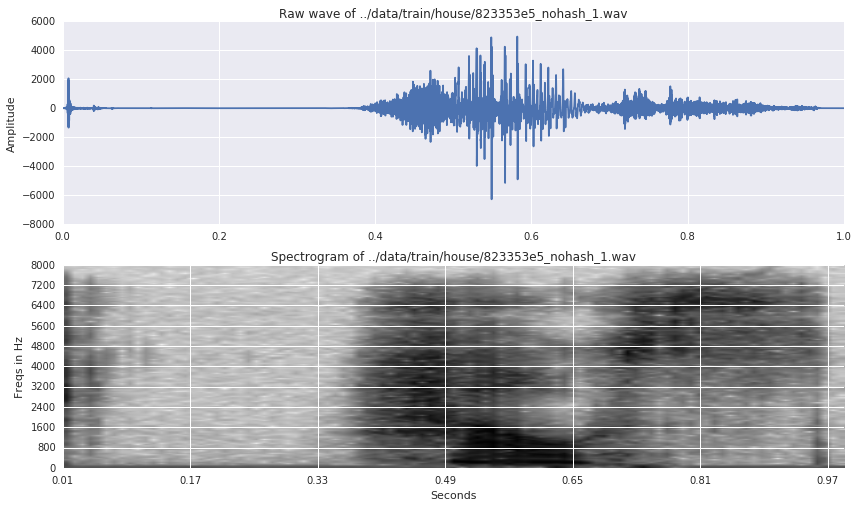

In [30]:
def visualize_wav(file_num):

  filename = train_files[file_num]

  sample_rate, samples = scipy.io.wavfile.read(filename)

  freqs, times, spectrogram = log_specgram(samples, sample_rate)

  fig = plt.figure(figsize=(14, 8))
  ax1 = fig.add_subplot(211)
  ax1.set_title('Raw wave of ' + filename)
  ax1.set_ylabel('Amplitude')
  ax1.plot(np.linspace(0, (sample_rate+0.0)/len(samples), sample_rate), samples)

  ax2 = fig.add_subplot(212)
  ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
             extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax2.set_yticks(freqs[::16])
  ax2.set_xticks(times[::16])
  ax2.set_title('Spectrogram of ' + filename)
  ax2.set_ylabel('Freqs in Hz')
  ax2.set_xlabel('Seconds')

visualize_wav(888)

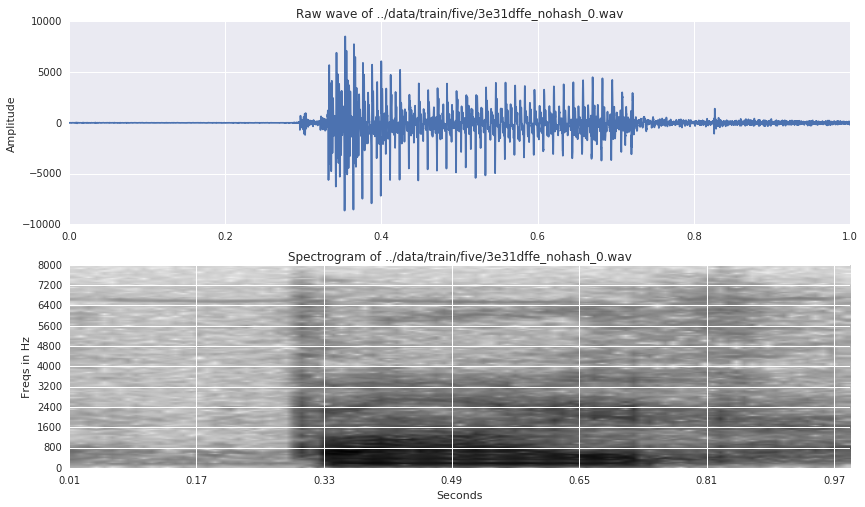

In [31]:
visualize_wav(999)

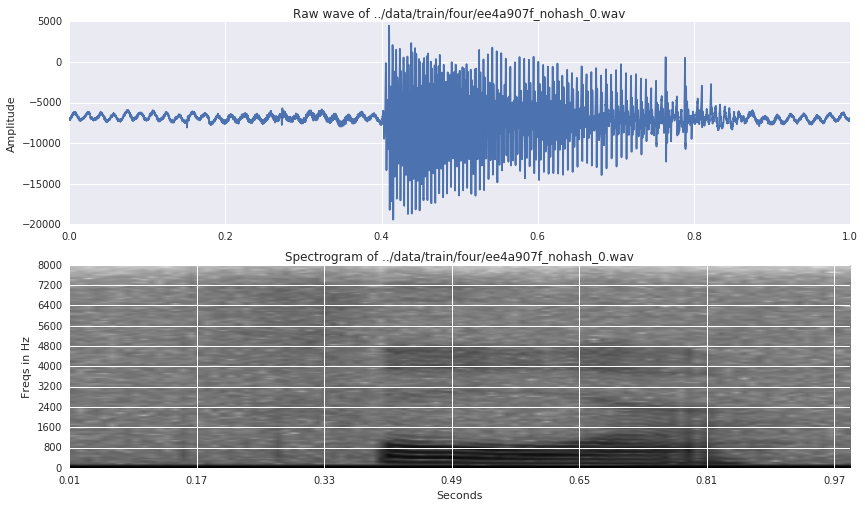

In [32]:
visualize_wav(111)

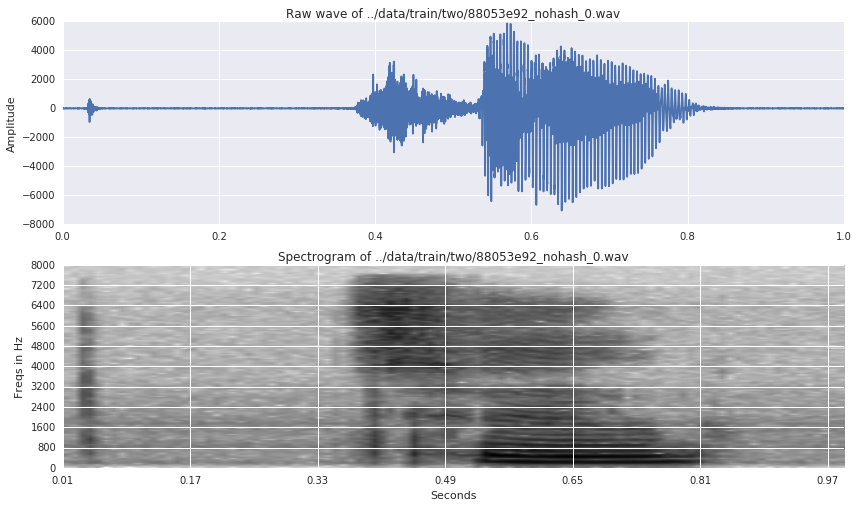

In [33]:
visualize_wav(333)

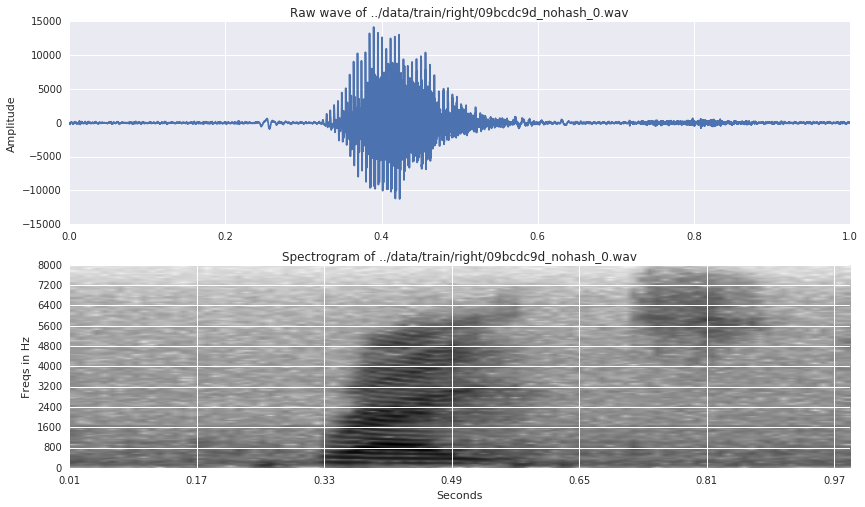

In [34]:
visualize_wav(334)

# to play the wav files

In [12]:
filename = train_files[16000]

print filename

sample_rate, samples = scipy.io.wavfile.read(filename)

ipd.Audio(samples, rate=sample_rate)

../data/train/two/cb8f8307_nohash_6.wav


In [13]:
#only play part of wav files
samples_cut = samples[4000:13000]

ipd.Audio(samples_cut, rate=sample_rate)

# Clean up the directory

In [14]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]

print dirs

print '\nNumber of labels:', len(dirs)

['seven', 'down', 'dog', 'eight', 'four', 'six', 'right', 'stop', 'tree', 'wow', 'two', 'marvin', 'yes', 'up', 'on', 'zero', 'no', 'bird', 'one', '_background_noise_', 'happy', 'sheila', 'three', 'house', 'five', 'off', 'nine', 'go', 'bed', 'cat', 'left']

Number of labels: 31


# Number of records for each labels and keep selected labels only

In [24]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

number_of_recordings = []

for folder in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, folder)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

print number_of_recordings

#plot

data = [go.Histogram(x=dirs, y=number_of_recordings)]

trace = go.Bar(
    x = dirs,
    y = number_of_recordings,
    marker = dict(color = number_of_recordings, colorscale = 'Viridius', showscale = True),
)

layout = go.Layout(
    title = 'Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)

py.iplot(go.Figure(data = [trace], layout = layout))

[1842, 1852, 1885, 1860, 1843, 1864, 1853, 1839, 1861, 1839]


# Length of recordings

In [20]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = scipy.io.wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

Number of recordings shorter than 1 second: 5204


In [28]:
spectrogram.shape

(99, 161)

['down', 'right', 'stop', 'yes', 'up', 'on', 'no', 'off', 'go', 'left']


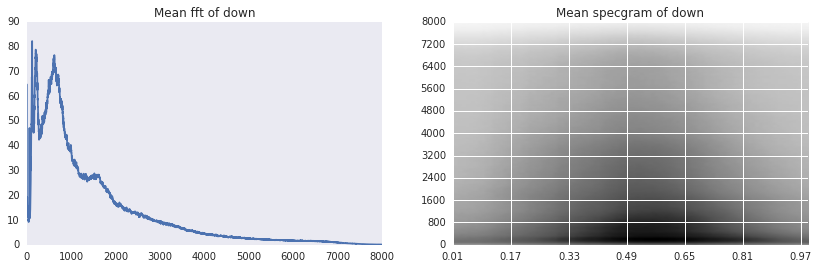

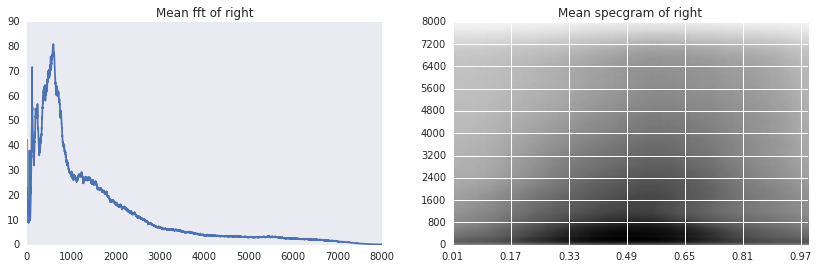

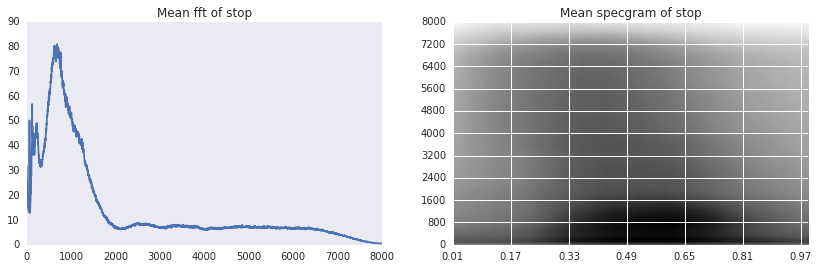

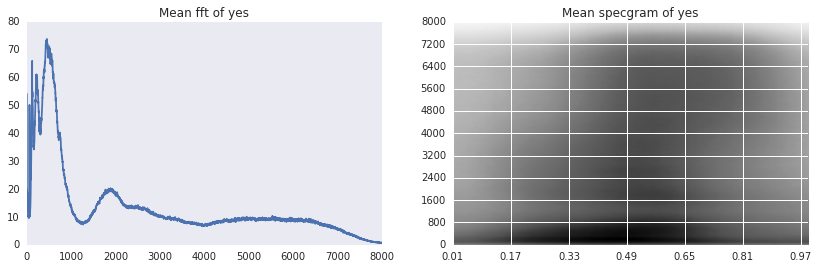

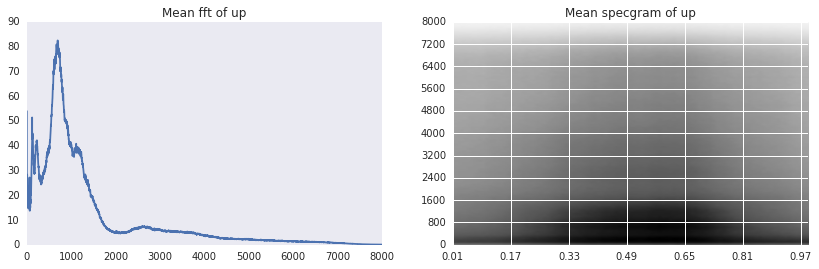

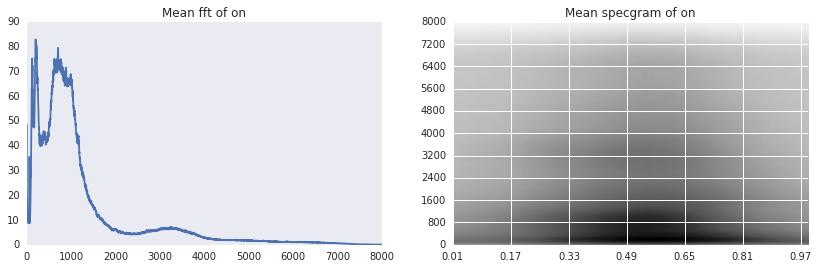

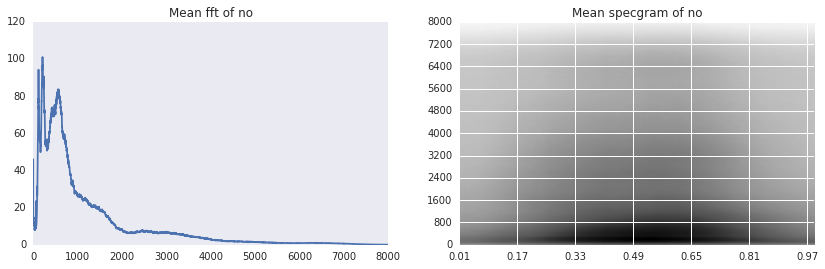

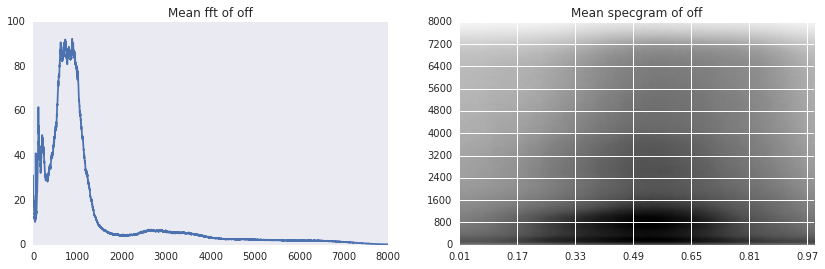

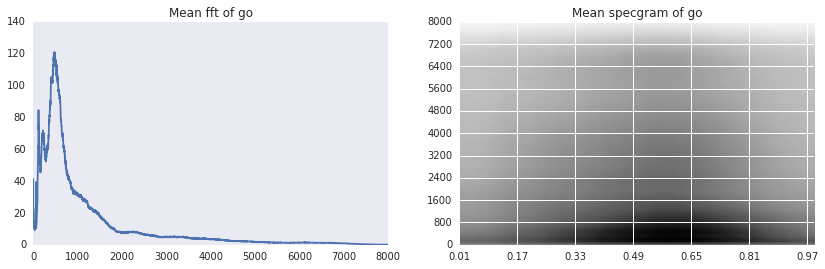

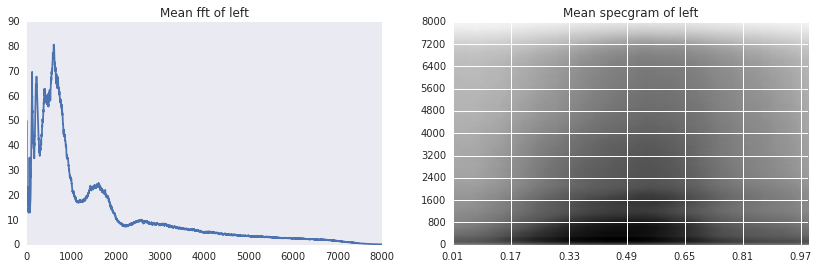

In [25]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = scipy.io.wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

In [27]:

folder = 'left'

for folder in dirs:
    for wav in os.listdir(join(train_audio_path, folder)):
        if wav.endswith('.wav'):
            sample_rate, samples = scipy.io.wavfile.read(train_audio_path + folder + '/' + wav)
            if (samples.shape[0]+0.0)/sample_rate > 1:
                print folder, wav, (samples.shape[0]+0.0)/sample_rate
